## Forecasting for Monitor

This notebook walks through building charts used in the Monitor application.

To run this notebook, start Jupyter as follows from the Django project root: <br>
(https://medium.com/ayuth/how-to-use-django-in-jupyter-notebook-561ea2401852)

`python manage.py shell_plus --notebook`

<br>
NOTE:  You will need to changed the kernel from menu: `Kernel` > `Change kernel` > `Django Shell-Plus`

In [1]:
import os
import logging
import pandas as pd
from pandas import Grouper
from pygam import LinearGAM, s, f
import matplotlib
import matplotlib.pyplot as plt
import pytz
import datetime
import numpy as np

from sklearn.metrics import r2_score #, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor

try:
    from django.db import models
    from traffic_monitor.models.model_logentry import LogEntry
    from traffic_monitor.models.model_monitor import Monitor
    

except Exception as e:
    print("NOT LOADED:  start notebook with:\n")
    print("\tpython manage.py shell_plus --notebook")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper, ColorBar, FixedTicker, NumeralTickFormatter

from bokeh.models import HoverTool, WheelZoomTool, ResetTool
from bokeh.models import Legend, LegendItem
from bokeh.plotting import figure
from bokeh.palettes import brewer, RdYlGn11
from bokeh.embed import components
from bokeh.embed import json_item
from bokeh.models import ColumnDataSource, HTMLTemplateFormatter, TableColumn, DataTable, HoverTool, \
    DatetimeTickFormatter, Line, FactorRange
from bokeh.plotting import figure
from django.http import JsonResponse
output_notebook()

Loading BokehJS ...

In [2]:
logger = logging.getLogger("model_logger")
logger.setLevel(logging.INFO)

## model_config.py

In [3]:
#  This module contains scripts used to support the forecasting process
import logging
import pytz
import datetime
import pickle
import os

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# from ..models.models import TrafficMonitorLogentry as LogEntry
# from ..models.models import TrafficMonitorMonitor as Monitor

logger = logging.getLogger("model_logger")
logger.setLevel(logging.INFO)

MODELS_DIR = 'app/trained_models'


class ModelConfig:
    # Use Pandas Timestamp for datetime to ensure DST conversions are consistent
    def __init__(self, monitor_name: str, interval: int, hours_in_training: int,
                 hours_in_prediction: int, string_predictor_columns: list = ['class_code'],
                 full_predictor_columns: list = None, response_columns: list = ['rate'],
                 source_data_from_date: str = None):
        self.monitor_name: str = monitor_name
        self.time_zone = Monitor.objects.get(pk=self.monitor_name).feed.time_zone
        self.interval: int = interval
        self.hours_in_training: int = hours_in_training
        self.hours_in_prediction: int = hours_in_prediction
        self.string_predictor_columns = string_predictor_columns
        self.predictor_columns = full_predictor_columns
        self.response_columns = response_columns
        self.from_date_utc = None if source_data_from_date is None else pd.Timestamp(source_data_from_date,
                                                                                     tz=self.time_zone).tz_convert(
            pytz.UTC)
        self.categories: list = Monitor.objects.get(pk=self.monitor_name).log_objects
        self.full_df: pd.DataFrame = None
        self.train_df: pd.DataFrame = None
        self.test_df: pd.DataFrame = None
        self.cat_to_code_map: dict = {c: i for i, c in enumerate(self.categories)}
        self.code_to_cat_map: dict = {v: k for k, v in self.cat_to_code_map.items()}

        self._set_dates()
        self._set_full_df()
        self._set_train_test_split()
        if self.predictor_columns is None:
            self._set_predictor_columns()

    def __str__(self):
        source_data_from_date = self.from_date_utc.tz_convert(pytz.timezone(self.time_zone)).replace(
            tzinfo=None).isoformat()
        save_params = {'monitor_name': self.monitor_name,
                       'interval': self.interval,
                       'hours_in_training': self.hours_in_training,
                       'hours_in_prediction': self.hours_in_prediction,
                       'string_predictor_columns': self.string_predictor_columns,
                       'full_predictor_columns': self.predictor_columns,
                       'response_columns': self.response_columns,
                       'source_data_from_date': source_data_from_date}
        return f"{save_params}"

    def get_score(self, trained_model) -> float:
        # Score the model
        _, _, test_X, test_y = self.get_train_test_split()
        return r2_score(y_true=test_y, y_pred=trained_model.predict(test_X))

    def get_code(self, category_name: str):
        return self.cat_to_code_map.get(category_name)

    def get_category(self, category_code: int):
        return self.code_to_cat_map.get(category_code)

    def _set_dates(self):
        if self.from_date_utc is None:
            self.from_date_utc = pd.Timestamp(
                LogEntry.objects.filter(monitor=self.monitor_name).earliest('time_stamp').time_stamp)

    def _get_logdata_df(self, from_date=None):
        # times returned are in UTC
        _filter_args = {'monitor_id': self.monitor_name}
        _filter_args.update({'class_name__in': self.categories})
        if from_date is None:
            _filter_args.update({'time_stamp__gte': self.from_date_utc})
        else:
            _filter_args.update({'time_stamp__gte': from_date})
        _df = pd.DataFrame(LogEntry.objects.filter(**_filter_args).all().values())

        if len(_df) == 0:
            raise Exception(
                f"No records returned: monitor:{self.monitor_name} from_date:{self.from_date_utc if from_date is None else from_date} categories:{self.categories}")

        # save the UTC times
        _df.insert(1, 'time_stamp_utc', _df['time_stamp'])
        # _df['time_stamp_utc'] = _df['time_stamp'].dt

        # convert time to monitor's timezone
        _df['time_stamp'] = _df['time_stamp'].dt.tz_convert(pytz.timezone(self.time_zone))
        return _df

    def _set_train_test_split(self):
        split_time = self.full_df.time_stamp.max() - pd.Timedelta(f"{self.hours_in_prediction + 1} hours")
        self.train_df = self.full_df[self.full_df.time_stamp < split_time]
        self.test_df = self.full_df[self.full_df.time_stamp >= split_time]

    def get_train_test_split(self):
        if self.train_df is None or self.test_df is None:
            self._set_train_test_split()

        _tr_x = self.train_df[self.predictor_columns].reset_index(drop=True)
        _te_x = self.test_df[self.predictor_columns].reset_index(drop=True)
        _tr_y = self.train_df[self.response_columns].reset_index(drop=True).to_numpy()
        _te_y = self.test_df[self.response_columns].reset_index(drop=True).to_numpy()

        # reshape single y columns
        if len(_tr_y.shape) > 1 and _tr_y.shape[1] == 1:
            _tr_y = _tr_y.reshape(-1)
        if len(_te_y.shape) > 1 and _te_y.shape[1] == 1:
            _te_y = _te_y.reshape(-1)

        return _tr_x, _tr_y, _te_x, _te_y

    def get_full_prediction_set(self):
        X = self.full_df[self.predictor_columns].reset_index(drop=True)
        y = self.full_df[self.response_columns].reset_index(drop=True)
        return X, y

    def _set_predictor_columns(self):
        """ Adds the history columns to a provided list of columns """
        self.predictor_columns = self.string_predictor_columns + [c for c in self.full_df.columns if c.startswith('-')][
                                                                 ::-1]

    def _set_interval(self, _df: pd.DataFrame, interval: int):
        """ Takes raw DF from Django call the LogEntry.objects.all().values() """
        """ 'interval' must divide hour into equal portions; 60, 30, 15, 10, 6, 4, 3, 2, 1"""
        if 60 % interval != 0:
            logger.error("Interval must be evenly divided into 60: (60, 30, 15, 10, 6, 4, 3, 2 or 1)")

        _df.rename(columns={'count': 'rate'}, inplace=True)

        # make columns categorical and remove multi_index
        # _df = _df.pivot_table(index=['time_stamp'], columns='class_name', values='rate', fill_value=0)
        _df = _df.pivot_table(index=['time_stamp_utc'], columns='class_name', values='rate', fill_value=0)

        _df.columns = _df.columns.get_level_values(0).values
        _df['year'] = pd.Series(_df.index).apply(lambda s: s.year).values
        _df['month'] = pd.Series(_df.index).apply(lambda s: s.month).values
        _df['day'] = pd.Series(_df.index).apply(lambda s: s.day).values
        _df['hour'] = pd.Series(_df.index).apply(lambda s: s.hour).values
        _df['interval'] = pd.Series(_df.index).apply(lambda s: int(s.minute / interval) * interval).values

        _df = _df.groupby(['year', 'month', 'day', 'hour', 'interval']).mean()

        # reconfigure index to a timestamp in UTC
        _df.set_index(pd.Series(list(_df.index)).apply(lambda s: datetime.datetime(*s, tzinfo=pytz.UTC)), inplace=True)

        # complete interval sequence
        start_time = _df.index.min()
        end_time = _df.index.max()
        new_interval = []
        t = start_time
        while t <= end_time:
            new_interval.append(t)
            t += pd.Timedelta(f"{interval} minutes")

        _df = pd.DataFrame(index=new_interval).join(_df, how='outer')

        # fill missing time intervals for forward filling the first half and backfilling the second half
        while _df.isna().any().any():
            _df.fillna(method='ffill', limit=1, inplace=True)
            _df.fillna(method='bfill', limit=1, inplace=True)

        _df = _df.melt(ignore_index=False, var_name='class_name', value_name='rate')

        _df = _df.reset_index().rename(columns={'index': 'time_stamp'})

        return _df

    def _add_categorical_column(self, _df, cat_col_name, code_col_name):
        idx = int(np.where(_df.columns == cat_col_name)[0][0])
        _df.insert(idx + 1, code_col_name, _df[cat_col_name].apply(lambda s: self.get_code(s)))
        return _df

    @staticmethod
    def add_time_features(_df: pd.DataFrame):
        """ add time characteristics that allow grouping """
        _df['year'] = pd.Series(_df.time_stamp).apply(lambda s: s.year).values
        _df['month'] = pd.Series(_df.time_stamp).apply(lambda s: s.month).values
        _df['day'] = pd.Series(_df.time_stamp).apply(lambda s: s.day).values
        _df['weekday'] = pd.Series(_df.time_stamp).apply(lambda s: s.weekday()).values
        _df['hour'] = pd.Series(_df.time_stamp).apply(lambda s: s.hour).values
        _df['minute'] = pd.Series(_df.time_stamp).apply(lambda s: s.minute).values
        _df['day_minute'] = pd.Series(_df.time_stamp).apply(lambda s: (s.hour * 60 + s.minute)).values
        _df['week_minute'] = pd.Series(_df.time_stamp).apply(
            lambda s: (s.weekday() * 24 * 60) + (s.hour * 60) + s.minute).values

        return _df

    def _add_history_columns(self, _df):
        # history columns are added to training datasets
        # value_column is the column to get the history for
        # n_intervals are the number of history columns to add
        categories = _df['class_name'].unique()
        n_intervals = self.hours_in_training * int(60 / self.interval)
        for i in range(1, n_intervals + 1):
            for c in categories:
                idx = _df.loc[_df['class_name'] == c].index
                _df.loc[idx, f'-{i}'] = _df[_df['class_name'] == c]['rate'].shift(i)
        _df.dropna(inplace=True)
        return _df.reset_index(drop=True)

    def _set_full_df(self):
        _df = self._get_logdata_df()
        _df = self._set_interval(_df, interval=self.interval)
        _df = self._add_categorical_column(_df, 'class_name', 'class_code')
        _df = self.add_time_features(_df)
        _df = self._add_history_columns(_df)

        self.full_df = _df # times are tz aware in UTC

    def get_seed_observation(self, on_date='latest'):
        # get the most recent observation or the first observation on a provided date
        # provided as from_date (is isoformat YYYY-MM_DDTHH:MM)
        # on_date is expected to be in the monitor's timezone

        # first, refresh the full set of data on which to base the forecast
        self._set_full_df()

        if on_date == 'latest' or on_date is None:
            on_date = self.full_df.time_stamp.max()
        else:
            on_date = pd.Timestamp(on_date)
            on_date = self.full_df.time_stamp[self.full_df.time_stamp >= on_date].min()

        _df = self.full_df[self.full_df.time_stamp == on_date]
        time_zero = _df['rate'].values

        # only keep the predictor columns
        _df = _df.reset_index(drop=True)[self.predictor_columns]
        _df["0"] = time_zero

        if len(_df) == 0:
            raise Exception(
                f"Unable to get forecasting seed: monitor:{self.monitor_name}, interval:{self.interval}, hours_in_prediction:{self.hours_in_prediction}, on_date:{on_date}, categories:{self.categories}")

        return _df, on_date

    def get_filename_stem(self):
        source_data_from_date = self.from_date_utc.tz_convert(pytz.timezone(self.time_zone)).replace(
            tzinfo=None).date().isoformat()
        filename = f"{self.monitor_name}_{self.interval}_{self.hours_in_training}_{self.hours_in_prediction}_{source_data_from_date}"
        return filename

    def is_saved(self) -> bool:
        """ Check if a file from a provied config already exists """
        filename = self.get_filename_stem()
        f = os.path.join(MODELS_DIR, filename + '.pkl')
        return os.path.exists(f)

    def save(self, trained_model):
        """ Save model parameters without data.  Fresh data is retrieved when configuration is loaded."""
        source_data_from_date = self.from_date_utc.tz_convert(pytz.timezone(self.time_zone)).replace(
            tzinfo=None).date().isoformat()

        save_params = {'config_args': {'monitor_name': self.monitor_name,
                                       'interval': self.interval,
                                       'hours_in_training': self.hours_in_training,
                                       'hours_in_prediction': self.hours_in_prediction,
                                       'string_predictor_columns': self.string_predictor_columns,
                                       'full_predictor_columns': self.predictor_columns,
                                       'response_columns': self.response_columns,
                                       'source_data_from_date': source_data_from_date},
                       'model_args': trained_model.get_params(),
                       'trained_model': trained_model}

        filename = self.get_filename_stem()

        f = os.path.join(MODELS_DIR, filename + '.pkl')

        if os.path.exists(f):
            os.remove(f)

        with open(f, 'xb') as pkl_file:
            pickle.dump(save_params, pkl_file)

        return filename

    @staticmethod
    def load(filename: str):
        """ Load model configuration.  Auto loads new observations from database. """
        filename = os.path.join(MODELS_DIR, filename)

        with open(filename + '.pkl', 'rb') as pkl_file:
            args = pickle.load(pkl_file)

        config_args = args.get('config_args')
        model_args = args.get('model_args')
        trained_model = args.get('trained_model')

        return config_args, model_args, trained_model

    @staticmethod
    def get_config_by_filename(filename: str):
        filename = os.path.join(MODELS_DIR, filename)

        if not os.path.isfile(filename + '.pkl'):
            return None

        with open(filename + '.pkl', 'rb') as pkl_file:
            args = pickle.load(pkl_file)

        config_args = args.get('config_args')

        return ModelConfig(**config_args)


<h1>Review Dataset</h1>
Visualize the dataset that we will be working with

In [14]:
monitor_name = 'MyMonitor'
interval = 60
hours_in_training = 24
hours_in_prediction = 24 * 7
source_data_from_date = '2020-10-01'
MODELS_DIR = '.'
model_config = ModelConfig(monitor_name=monitor_name, interval=60,
            hours_in_prediction=hours_in_prediction, 
            hours_in_training=hours_in_training, 
            source_data_from_date="2020-10-01", string_predictor_columns=["class_code", "weekday", "hour"])

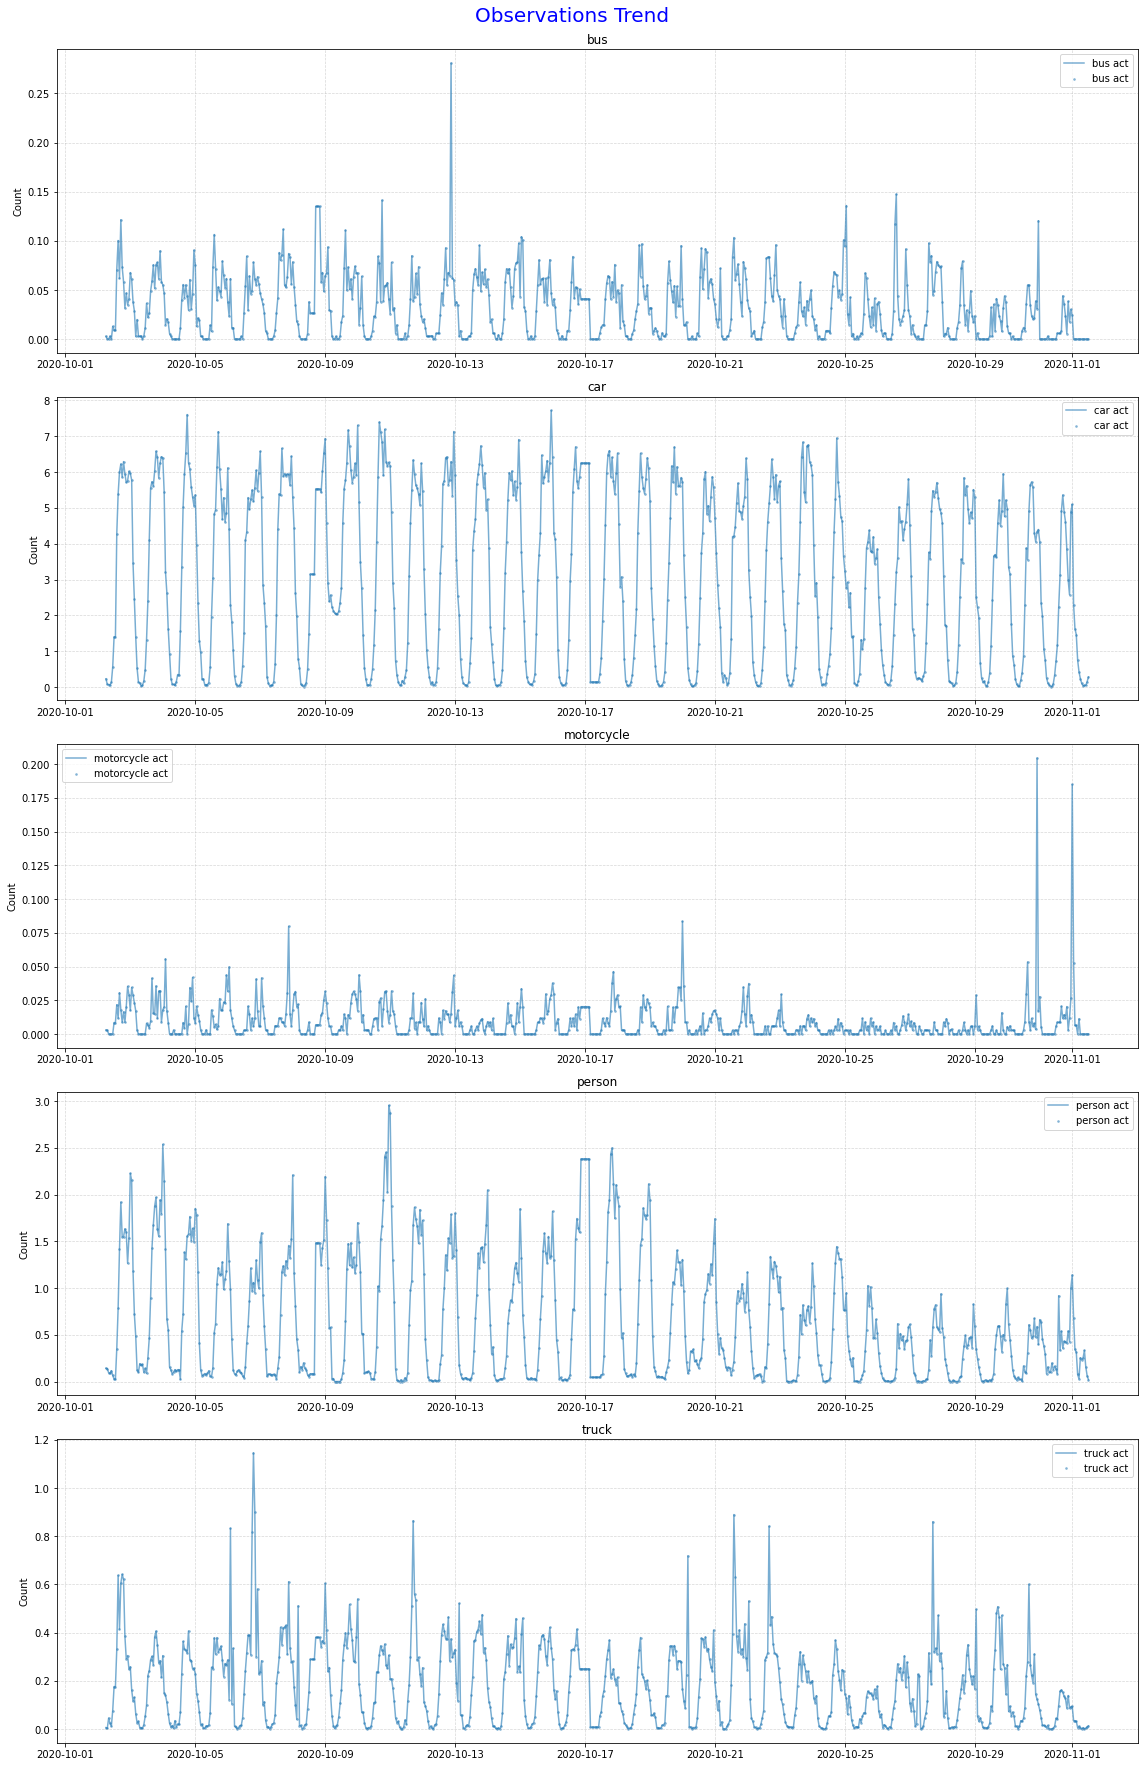

In [15]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Observations Trend\n", fontsize=20, c='b')

plot_df = model_config.full_df

for i, c in enumerate(plot_df.class_name.unique()):
    _p = plot_df[plot_df.class_name == c]
    subplot[i].scatter(_p.time_stamp, _p.rate, alpha=.4, label=f"{c} act", s=3)
    subplot[i].plot(_p.time_stamp, _p.rate, alpha=.6, label=f"{c} act")
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [16]:
print(f"{'Object':15}  {'Count':>10}")
for c in model_config.full_df.class_name.unique():
    print(f"{c:15}  {(model_config.full_df[model_config.full_df.class_name == c]['rate'] != 0).sum():>10}")

Object                Count
bus                     570
car                     727
motorcycle              475
person                  703
truck                   700


<h1>Predict Based on Weekday Average</h1>
Predict based on each day's average.

In [17]:
weekdayavg_train_df = model_config.train_df[['weekday', 'class_name', 'rate']].groupby(['weekday', 'class_name']).agg([np.mean, np.std])
weekdayavg_test_df = model_config.test_df[['weekday', 'class_name', 'rate']].groupby(['weekday', 'class_name']).agg([np.mean, np.std])

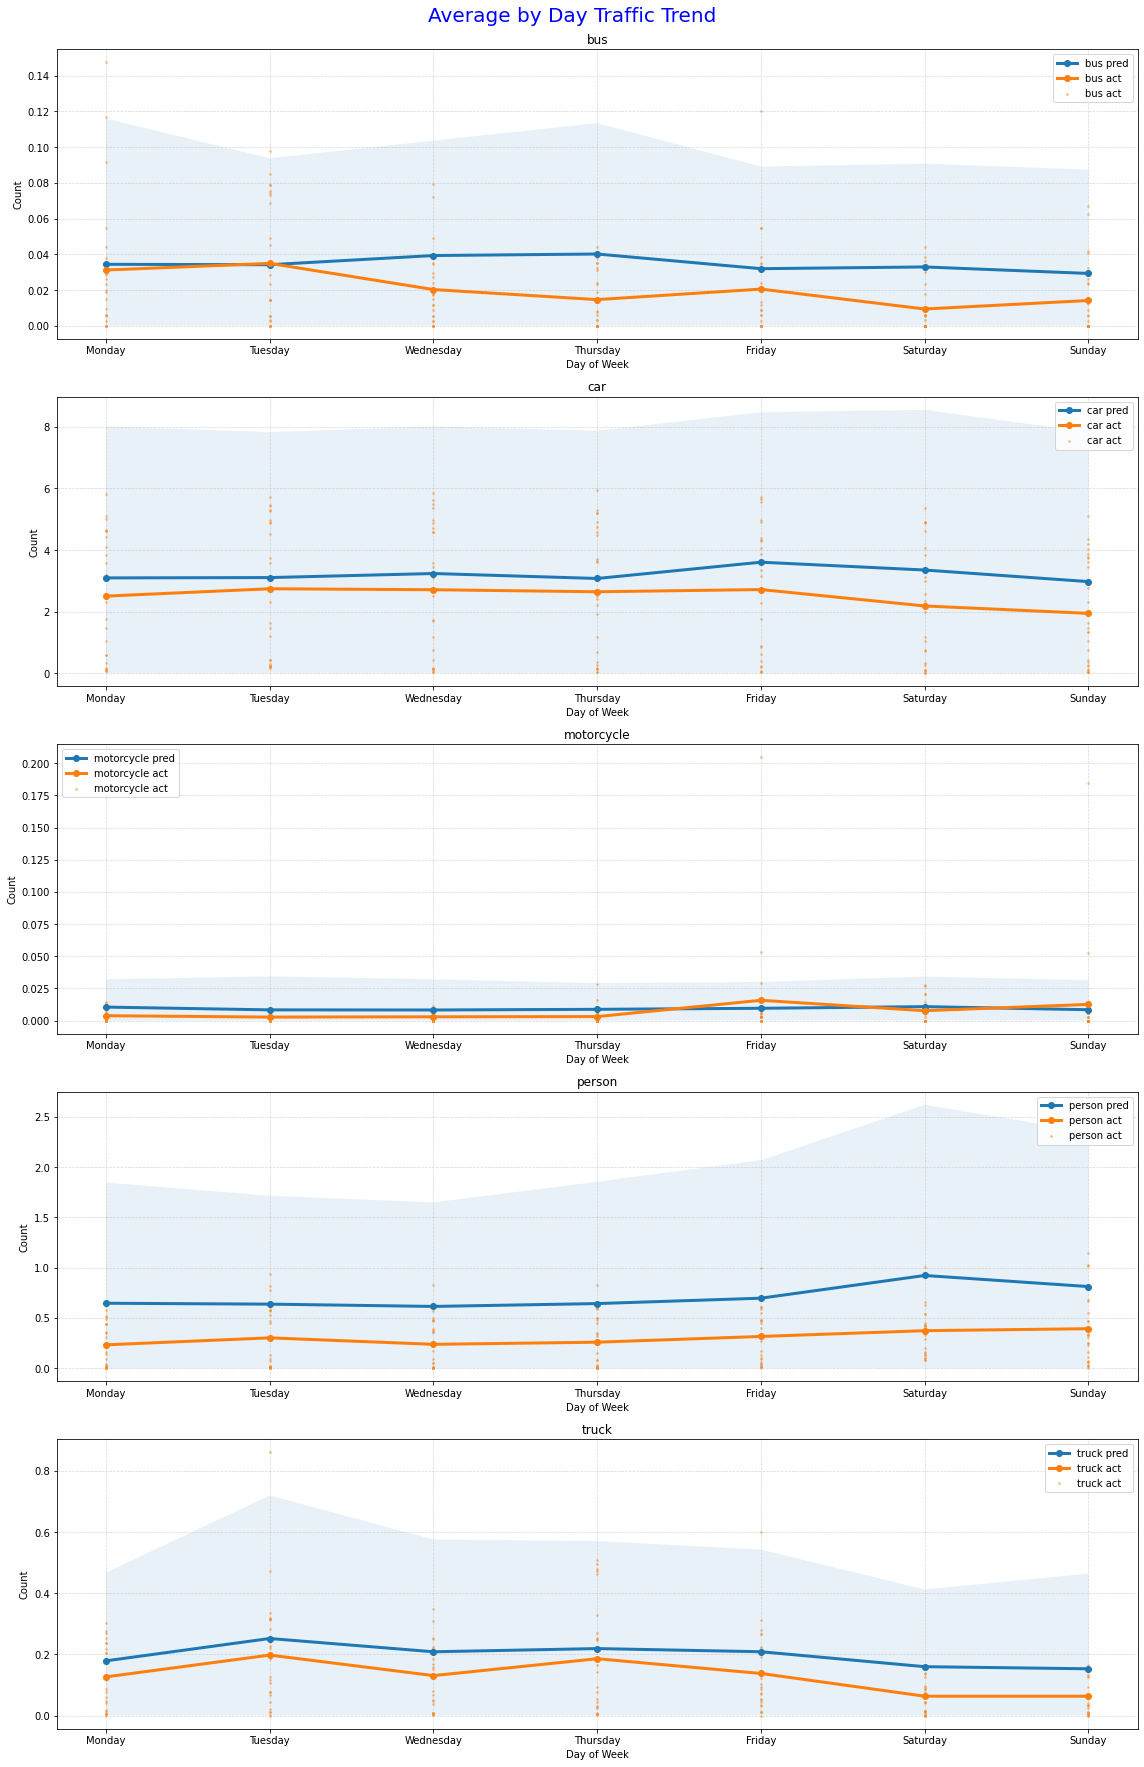

In [18]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Day Traffic Trend\n", fontsize=20, c='b')

_train_df = weekdayavg_train_df
_test_df = weekdayavg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(model_config.test_df[model_config.test_df.class_name == c].weekday, model_config.test_df[model_config.test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Day of Week")
    tick_locations = range(0,7)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

Measure accuracy

In [19]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(weekdayavg_test_df.index.get_level_values(1).unique()):
    true = weekdayavg_test_df[weekdayavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = weekdayavg_train_df[weekdayavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus          -2.727
car          -6.166
motorcycle   -0.197
person      -47.936
truck        -1.113


<h1>Predict by Hour of Day</h1>
Predict based on the time of day.

In [20]:
houravg_train_df = model_config.train_df[['hour', 'class_name', 'rate']].groupby(['hour', 'class_name']).agg([np.mean, np.std])
houravg_test_df = model_config.test_df[['hour', 'class_name', 'rate']].groupby(['hour', 'class_name']).agg([np.mean, np.std])


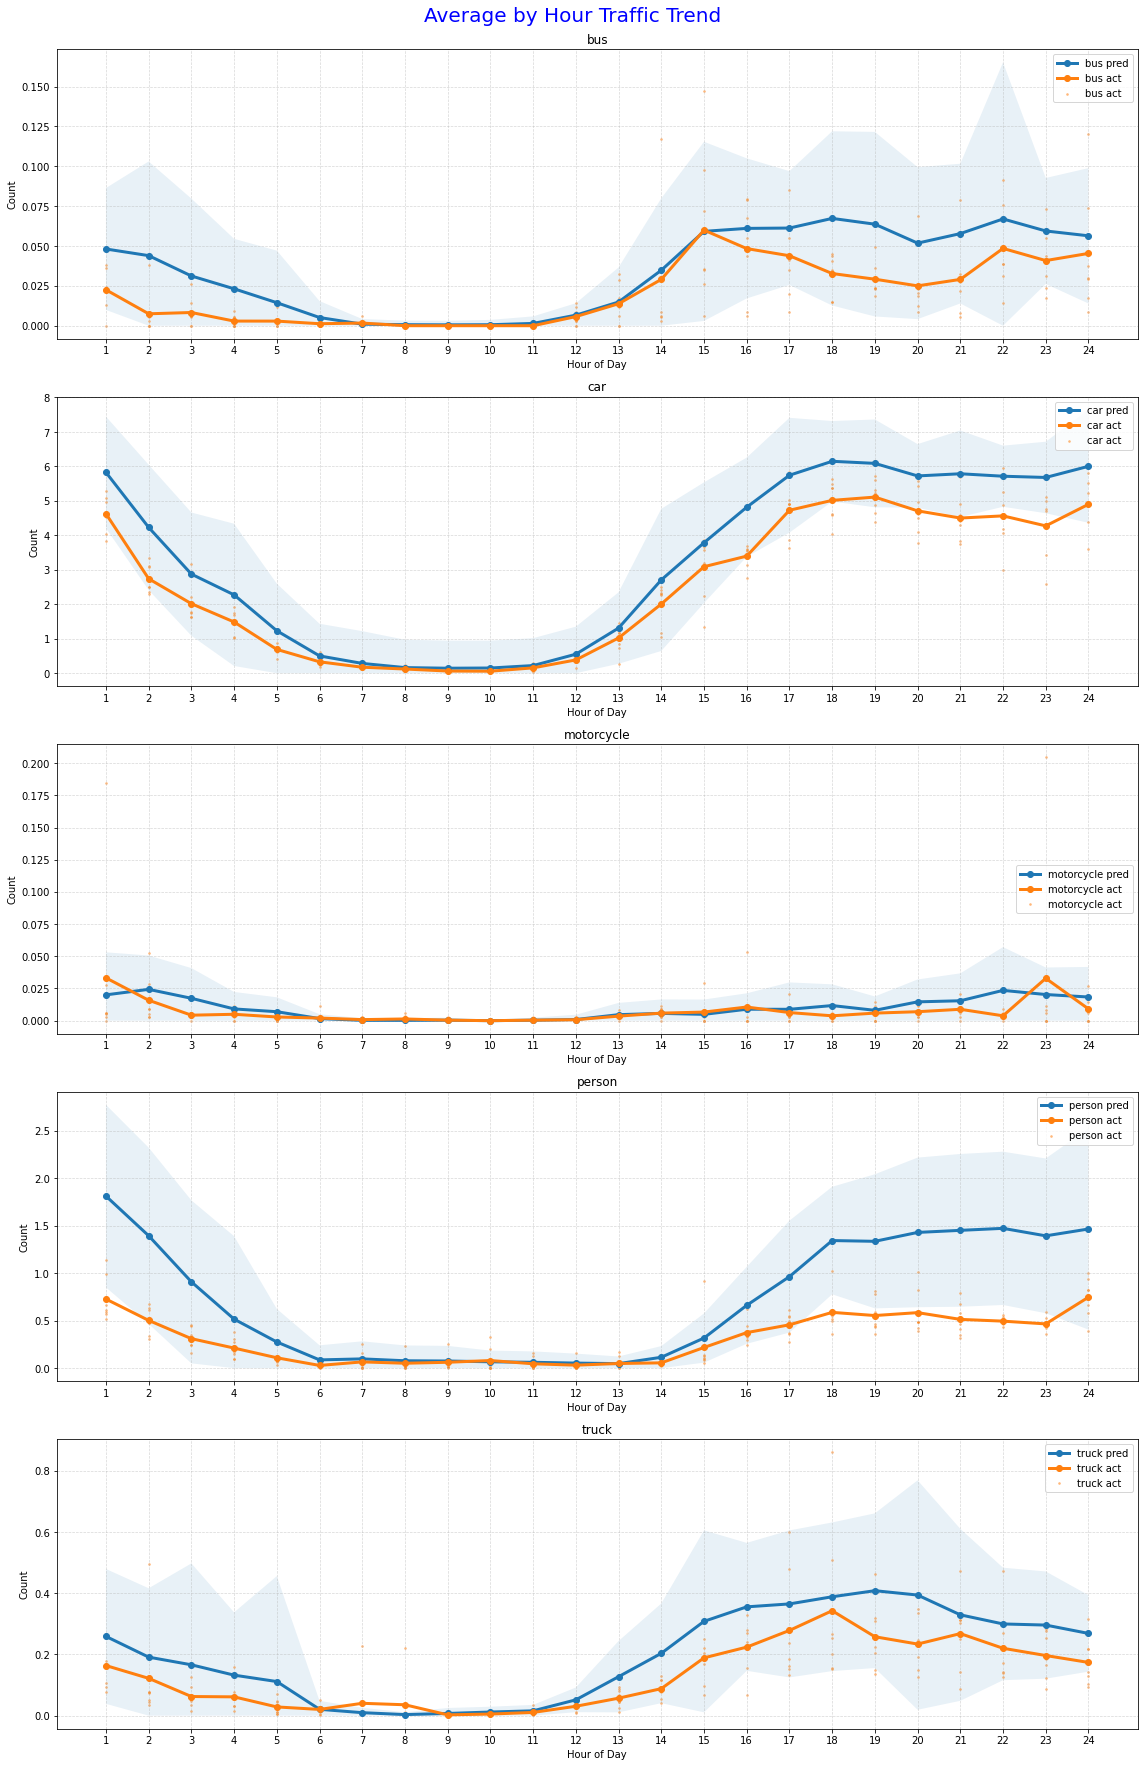

In [21]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Hour Traffic Trend\n", fontsize=20, c='b')

_train_df = houravg_train_df
_test_df = houravg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(model_config.test_df[model_config.test_df.class_name == c].hour, model_config.test_df[model_config.test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Hour of Day")
    tick_locations = range(0,24)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(range(1,25))
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [22]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(houravg_test_df.index.get_level_values(1).unique()):
    true = houravg_test_df[houravg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = houravg_train_df[houravg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus           0.045
car           0.791
motorcycle    0.291
person       -4.661
truck         0.306


<h1>Predict by X minute Interval of Day</h1>
Predict based on the time of day.

In [23]:
intavg_train_df = model_config.train_df[['day_minute', 'class_name', 'rate']].groupby(['day_minute', 'class_name']).agg([np.mean, np.std])
intavg_test_df = model_config.test_df[['day_minute', 'class_name', 'rate']].groupby(['day_minute', 'class_name']).agg([np.mean, np.std])


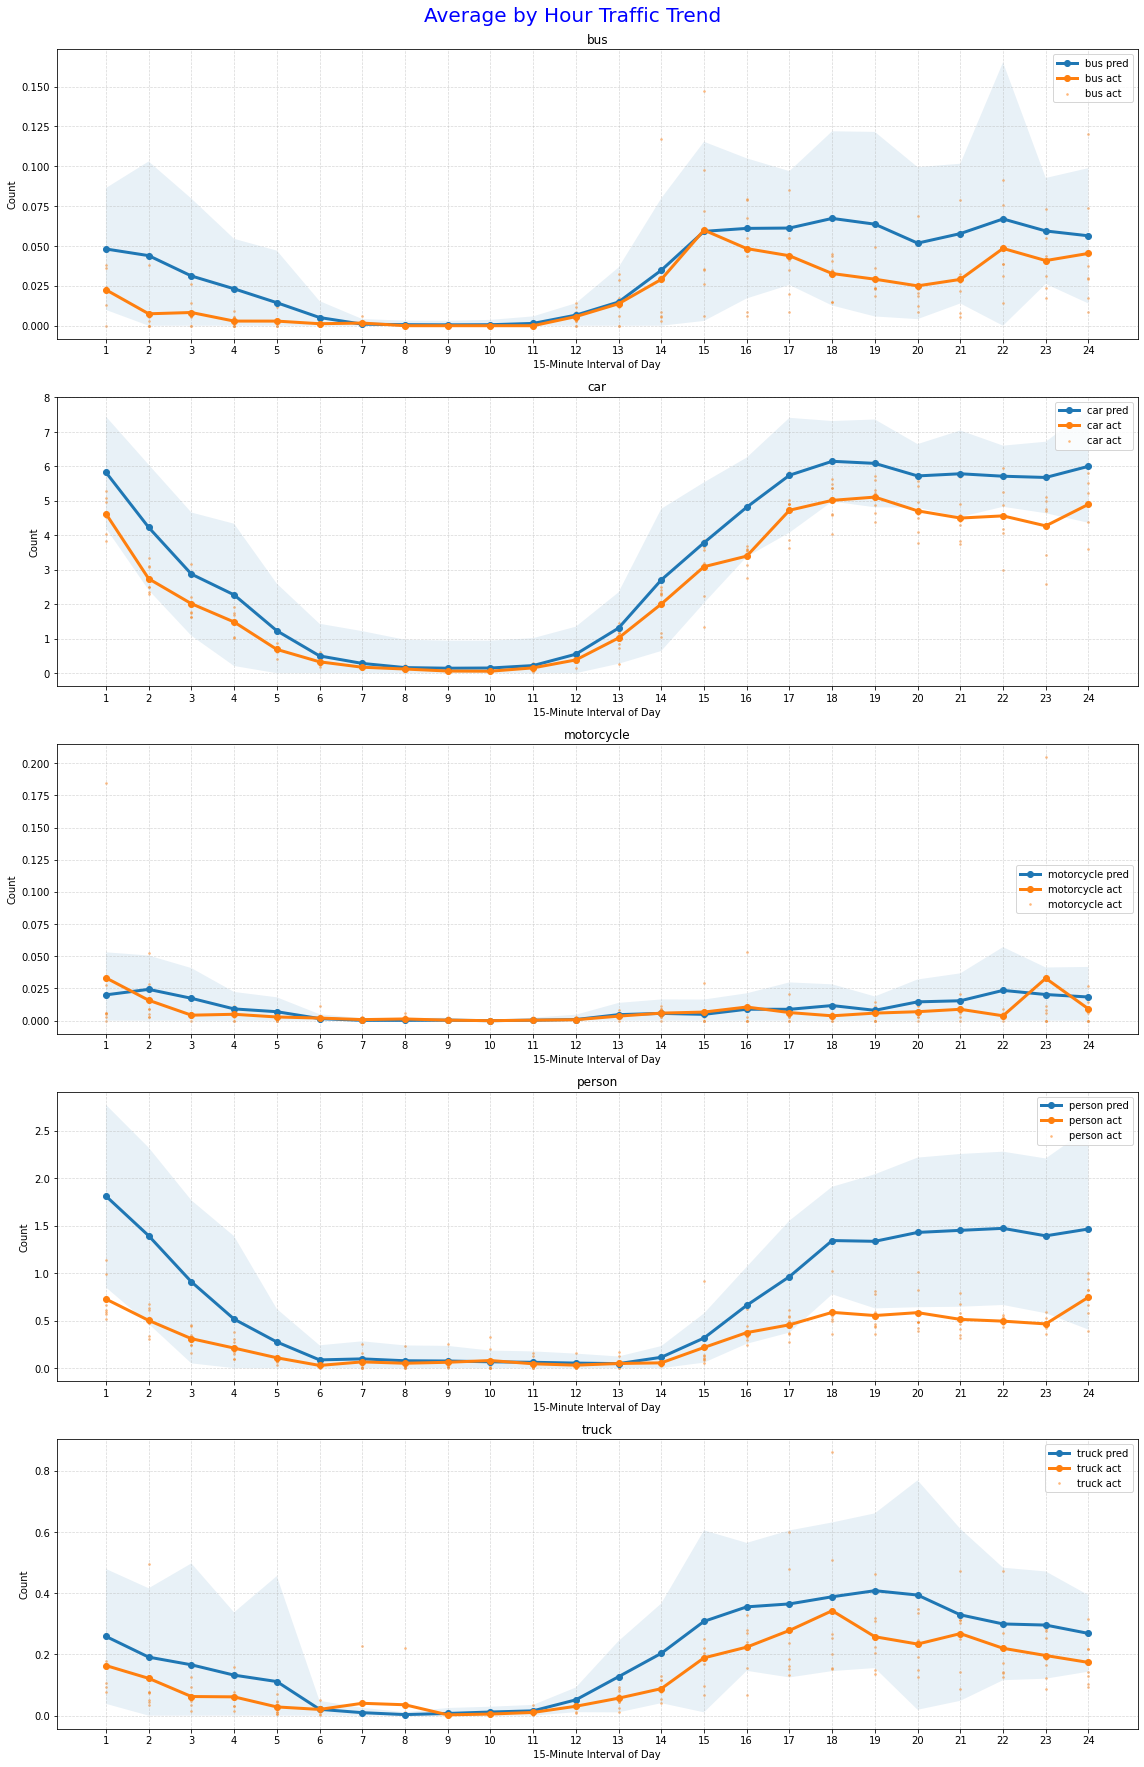

In [24]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Hour Traffic Trend\n", fontsize=20, c='b')

_train_df = intavg_train_df
_test_df = intavg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(model_config.test_df[model_config.test_df.class_name == c].day_minute, model_config.test_df[model_config.test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("15-Minute Interval of Day")
    tick_locations = range(0,60*24, 60)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(range(1,25))
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [25]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(intavg_test_df.index.get_level_values(1).unique()):
    true = intavg_test_df[intavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = intavg_train_df[intavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus           0.045
car           0.791
motorcycle    0.291
person       -4.661
truck         0.306


<h1>Predict by Time of Day and Day of Week</h1>
Use the time of the day and the day of the week.

In [26]:
weekminavg_train_df = model_config.train_df[['week_minute', 'class_name', 'rate']].groupby(['week_minute', 'class_name']).agg([np.mean, np.std])
weekminavg_test_df = model_config.test_df[['week_minute', 'class_name', 'rate']].groupby(['week_minute', 'class_name']).agg([np.mean, np.std])


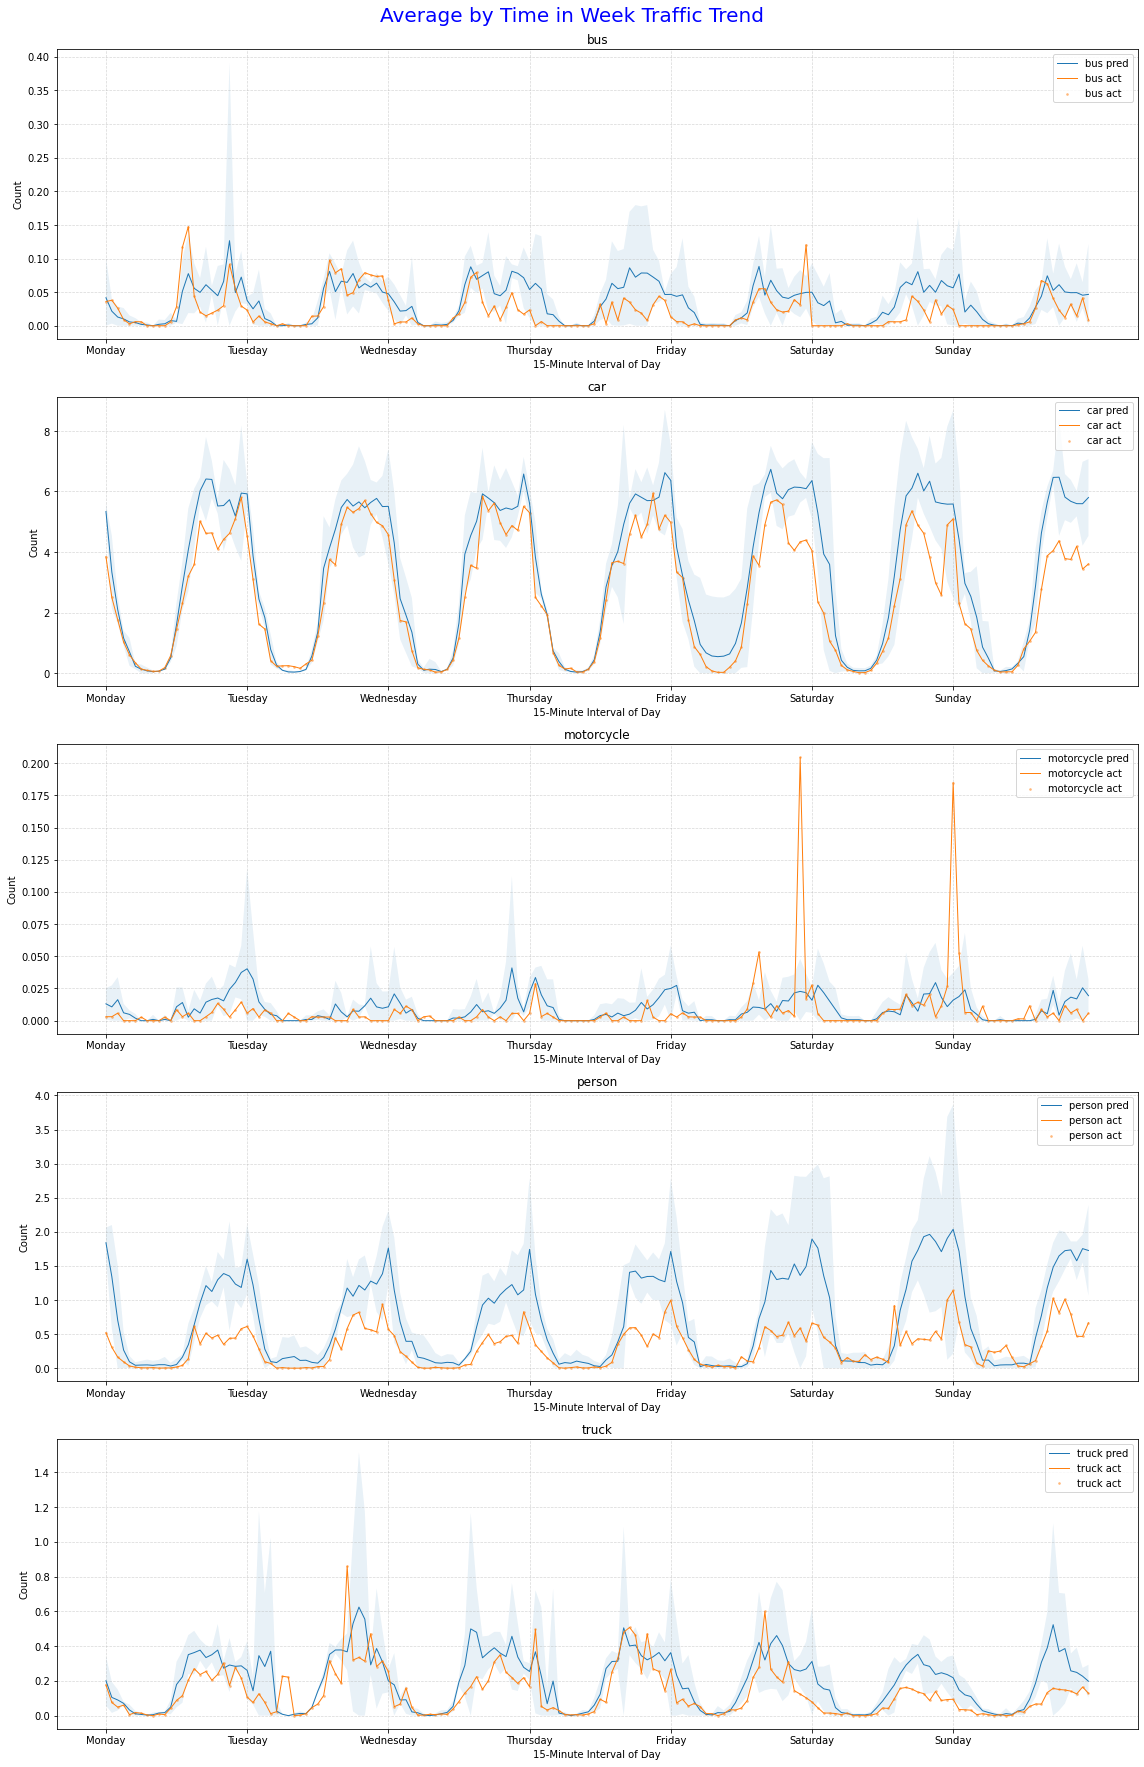

In [27]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Time in Week Traffic Trend\n", fontsize=20, c='b')

_pred_df = weekminavg_train_df
_test_df = weekminavg_test_df

for i, c in enumerate(_pred_df.index.get_level_values(1).unique()):
    _pr_df = _pred_df[_pred_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", lw=1)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(_te_df.index.get_level_values(0), _te_df.rate['mean'], alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", lw=1)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("15-Minute Interval of Day")
    tick_locations = range(0,24*7*60,24*60)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [28]:
for i, c in enumerate(weekminavg_test_df.index.get_level_values(1).unique()):
    true = weekminavg_test_df[weekminavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = weekminavg_train_df[weekminavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

bus          -0.023
car           0.731
motorcycle    0.013
person       -3.599
truck         0.106


<h1>Baseline Model Results</h1>

<b>Weekday Average</b> <br>
This is the worst performing model and is no surprise.  Here, we predict the observation rate based on the overall average of each day of the week.  This will take into account that some days are busier than others, but does not consider the time of day when making prdictions.

<b>Time of Day</b> <br>
Making predictions based on the time of the day yields better results.  Here, we consider the time of the day, but not the day of the week.

<b>Day and Time</b> <br>
Lastly, we use both the day of the week and the time of the day to make prdictions.  Both the R2 and MSE scores improve which makes sense and is expected.  We will consider this our baseline model.